System information (for reproducibility):

In [1]:
versioninfo()

Julia Version 1.8.5
Commit 17cfb8e65ea (2023-01-08 06:45 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.5.0)
  CPU: 8 × Apple M2
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, apple-m1)
  Threads: 4 on 4 virtual cores
Environment:
  JULIA_NUM_THREADS = 4


Load packages:

In [2]:
using Pkg

Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Library/CloudStorage/Dropbox/Mac/Documents/biostat257/biostat-257-2023-spring/hw2`


Status `~/Library/CloudStorage/Dropbox/Mac/Documents/biostat257/biostat-257-2023-spring/hw2/Project.toml`
  [6e4b80f9] BenchmarkTools v1.3.2
  [7073ff75] IJulia v1.24.0
  [916415d5] Images v0.25.2
  [bdcacae8] LoopVectorization v0.12.157
  [8bb1440f] DelimitedFiles
  [37e2e46d] LinearAlgebra
  [9abbd945] Profile


In [3]:
# load libraries
using BenchmarkTools, DelimitedFiles, Images, LinearAlgebra, LoopVectorization
using Profile, Random

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an alternative to principal components and vector quantization with applications in data compression, clustering, and deconvolution. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).

<img src="./nnmf.png" width="500" align="center"/>

In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Lee and Seung suggest an iterative algorithm with multiplicative updates
$$
v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that will drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates the iteration number. In following questions, efficiency (both speed and memory) will be the most important criterion when grading this problem.

### Q1.1 Develop code

Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.

In [4]:
function squared_frobenius_norm(A::Matrix, B::Matrix)
    result = 0.0
    @turbo for i in eachindex(A)
        result += (A[i] - B[i])^2
    end
    return result
end
function nnmf(
    # positional arguments
    X       :: AbstractMatrix{T}, 
    r       :: Integer;
    # kw arguments
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,      
    niter   :: Number = 0,
    obj     :: Number = 0.0,
    obj_ref :: Number = 0.0,
    obj_dif :: Number = 0.0,
    V       :: AbstractMatrix{T} = Random.rand!(similar(X, size(X, 1), r)),
    VtV     :: AbstractMatrix{T} = zeros(r, r),
    W       :: AbstractMatrix{T} = Random.rand!(similar(X, r, size(X, 2))),
    WWt     :: AbstractMatrix{T} = zeros(r, r),
    b       :: AbstractMatrix{T} = zeros(size(X, 1), size(X, 2)),
    temp1   :: AbstractMatrix{T} = zeros(size(X, 1), r),
    temp2   :: AbstractMatrix{T} = zeros(size(X, 1), r),
    temp3   :: AbstractMatrix{T} = zeros(r, size(X, 2)),
    temp4   :: AbstractMatrix{T} = zeros(r, size(X, 2))
    ) where T <: AbstractFloat
    ni, nj = size(X)
    for n = 1:maxiter
        # V .= V .* (X * W') ./ (V * (W * W'))
        # W .= W .* (V' * X) ./ ((V' * V) * W)
        mul!(WWt, W, transpose(W))
        mul!(temp1, X, transpose(W))
        BLAS.symm!('R', 'U', 1.0, WWt, V, 0.0, temp2)       
        #V .= V .* temp1 ./ temp2
        for k = 1:r, i = 1:ni 
            V[i, k] = V[i, k] * temp1[i, k] / temp2[i, k]
        end
        mul!(VtV, transpose(V), V)
        mul!(temp3, transpose(V), X)        
        BLAS.symm!('L', 'U', 1.0, VtV, W, 0.0, temp4)
        #W .= W .* temp3 ./ temp4
        for j = 1:nj, k = 1:r 
            W[k, j] = W[k, j] * temp3[k, j] / temp4[k, j]
        end
        mul!(b, V, W)
        #@tturbo for j = 1:nj, i = 1:ni
        #    obj += (X[i, j] - b[i, j])^2            
        #end
        #@turbo for i in eachindex(X)
        #    obj += (X[i] - b[i])^2
        #end
        obj = squared_frobenius_norm(X, b)
        obj_dif = abs((obj - obj_ref) / (obj_ref + 1))
        if obj_dif < tolfun
            niter = n
            break
        else
            obj_ref = obj
            obj = 0
        end   
    end
    V, W, obj, niter
end
r = 10
X = readdlm("nnmf-2429-by-361-face.txt")
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64)
V0 = V0full[:, 1:r]
W0 = W0full[1:r, :]
V, W, obj, niter = nnmf(X, r, V = V0, W = W0)

([0.11851552506050562 0.029940503455097002 … 0.0028830808553836716 0.06420991048712577; 0.13176807592569637 0.00043091681623598683 … 0.014863431363093793 0.03502874558367149; … ; 0.05270583755824649 0.047940980051639846 … 0.17001962787982652 0.04626182097825291; 0.1293301467941607 0.019567810402128072 … 0.09435983264067124 0.02958077729187712], [3.3858852358469236e-27 1.1745375738681195e-27 … 0.23001933337974995 2.280168625090756e-6; 0.010899790573386931 1.7007366080211302e-6 … 9.16578702078174e-15 5.134415347265677e-11; … ; 4.0722852963976007e-10 0.00011974641917549178 … 6.611383816440977e-6 1.3798984047396887e-12; 5.698509363463876e-10 6.9805007007866184e-9 … 2.231852944090882e-14 1.8764490698062524e-18], 11730.388009854814, 239)

### Q1.2 Data

Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu/software-datasets/FaceData2.html) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  

Read in the [`nnmf-2429-by-361-face.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2023spring/master/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm`](https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/#Delimited-Files) function, and display a couple of sample images, e.g., using the [Images.jl](https://juliaimages.org/stable/) package.

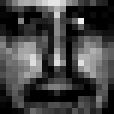

In [5]:
X = readdlm("nnmf-2429-by-361-face.txt")
colorview(Gray, reshape(X[1, :], 19, 19))

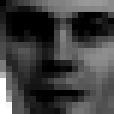

In [6]:
colorview(Gray, reshape(X[10, :], 19, 19))

###### Q1.3 Correctness and efficiency

Report the run times, using `@btime`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2023spring/master/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2023spring/master/hw/hw2/W0.txt)) and stopping criterion
$$
\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

**Hint**: When I run the following code using my own implementation of `nnmf`
```julia
# provided start point
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64);

# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    _, _, obj, niter = nnmf(X, r, V = V0, W = W0)
    @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
        copyto!(V0, V0full[:, 1:r]), 
        copyto!(W0, W0full[1:r, :])
        )
    println("obj=$obj, niter=$niter")
end
```
the output is
```
r=10
  162.662 ms (9 allocations: 437.19 KiB)
obj=11730.866905748058, niter=239
r=20
  234.293 ms (9 allocations: 875.44 KiB)
obj=8497.605595863002, niter=394
r=30
  259.524 ms (9 allocations: 1.28 MiB)
obj=6621.94596847528, niter=482
r=40
  289.918 ms (9 allocations: 1.72 MiB)
obj=5256.866299829562, niter=581
r=50
  397.511 ms (10 allocations: 2.15 MiB)
obj=4430.362097310877, niter=698
```
Due to machine differences, your run times can be different from mine but certainly can not be order of magnitude longer. Your memory allocation should be less or equal to mine.

In [7]:
# provided start point
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64);

# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    ni, nj = size(X)
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    b = zeros(ni, nj)
    WWt = zeros(r, r)
    VtV = zeros(r, r)
    temp1 = zeros(ni, r)
    temp2 = zeros(ni, r)
    temp3 = zeros(r, nj)
    temp4 = zeros(r, nj)
    V, W, obj, niter = nnmf(X, r, V = V0, W = W0, b = b,
                            WWt = WWt, VtV = VtV,
                            temp1 = temp1, temp2 = temp2,
                            temp3 = temp3, temp4 = temp4)
    @btime nnmf($X, $r, V = $V0, W = $W0, b = $b,
                WWt = $WWt, VtV = $VtV,
                temp1 = $temp1, temp2 = $temp2,
                temp3 = $temp3, temp4 = $temp4) setup=(
        copyto!(V0, V0full[:, 1:r]), 
        copyto!(W0, W0full[1:r, :])
        )
    println("obj=$obj, niter=$niter")
end

r=10
  326.918 ms (2 allocations: 64 bytes)
obj=11730.388009854814, niter=239
r=20
  378.116 ms (2 allocations: 64 bytes)
obj=8497.222317850323, niter=394
r=30
  532.195 ms (2 allocations: 64 bytes)
obj=6621.627345486277, niter=482
r=40
  506.569 ms (2 allocations: 64 bytes)
obj=5256.66387056352, niter=581
r=50
  647.179 ms (2 allocations: 64 bytes)
obj=4430.201581697291, niter=698


### Q1.4 Non-uniqueness

Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

In [8]:
Random.seed!(257)
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    ni, nj = size(X)
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    b = zeros(ni, nj)
    WWt = zeros(r, r)
    VtV = zeros(r, r)
    temp1 = zeros(ni, r)
    temp2 = zeros(ni, r)
    temp3 = zeros(r, nj)
    temp4 = zeros(r, nj)
    V, W, obj, niter = nnmf(X, r, b = b,
                            WWt = WWt, VtV = VtV,
                            temp1 = temp1, temp2 = temp2,
                            temp3 = temp3, temp4 = temp4)
    @btime nnmf($X, $r, b = $b,
                WWt = $WWt, VtV = $VtV,
                temp1 = $temp1, temp2 = $temp2,
                temp3 = $temp3, temp4 = $temp4) setup=(
        copyto!(V0, V0full[:, 1:r]), 
        copyto!(W0, W0full[1:r, :])
        )
    println("obj=$obj, niter=$niter")
end

r=10
  243.984 ms (3917 allocations: 319.17 KiB)
obj=11664.751247649094, niter=226
r=20
  696.230 ms (7275 allocations: 623.80 KiB)
obj=8388.335892971132, niter=427
r=30
  1.004 s (8793 allocations: 880.92 KiB)
obj=6589.313594497118, niter=483
r=40
  1.366 s (11277 allocations: 1.14 MiB)
obj=5388.84270206944, niter=667
r=50
  2.343 s (15625 allocations: 1.46 MiB)
obj=4441.579618064008, niter=639


### Q1.5 Fixed point

For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

In [9]:
Random.seed!(257)
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    ni, nj = size(X)
    V0 = ones(ni, r)
    W0 = ones(r, nj)
    b = zeros(ni, nj)
    WWt = zeros(r, r)
    VtV = zeros(r, r)
    temp1 = zeros(ni, r)
    temp2 = zeros(ni, r)
    temp3 = zeros(r, nj)
    temp4 = zeros(r, nj)
    V, W, obj, niter = nnmf(X, r, V = V0, W = W0, b = b,
                            WWt = WWt, VtV = VtV,
                            temp1 = temp1, temp2 = temp2,
                            temp3 = temp3, temp4 = temp4)
    @btime nnmf($X, $r, V = $V0, W = $W0, b = $b,
                WWt = $WWt, VtV = $VtV,
                temp1 = $temp1, temp2 = $temp2,
                temp3 = $temp3, temp4 = $temp4) setup=(
        copyto!(V0, V0full[:, 1:r]), 
        copyto!(W0, W0full[1:r, :])
        )
    println("obj=$obj, niter=$niter")
end

r=10
  313.784 ms (5500 allocations: 141.98 KiB)
obj=25297.01651108185, niter=4
r=20
  430.837 ms (4810 allocations: 124.17 KiB)
obj=25297.01651108185, niter=4
r=30
  450.216 ms (4281 allocations: 110.52 KiB)
obj=25297.01651108185, niter=4
r=40
  814.794 ms (5776 allocations: 149.11 KiB)
obj=25297.01651108185, niter=4
r=50
  827.374 ms (5454 allocations: 140.80 KiB)
obj=25297.01651108185, niter=4


### Q1.6 Interpret NNMF result

Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

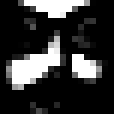

In [10]:
Random.seed!(257)
V, W, obj, niter = nnmf(X, 50)
colorview(Gray, reshape(W[1, :], 19, 19))

### Q1.7 GPU (optional)

Investigate the GPU capabilities of Julia. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in Q1.3.